# Assignment 4: Movie Review Analysis [50 Pt]

In this assignment, we will build a recurrent neural network to work with sequential text data, specificially, movie review data to identify the reviewer sentiment. In the process of completing this assignment, you will:
    
1. Clean and process text data for machine learning.
2. Perform tokenization of text data.
3. Understand and implement a word-level recurrent neural network.
4. Implement batching of text data using a DataLoader before training a recurrent neural network.
5. Understand how to apply pretrained models for transfer learning in natural language processing projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your Colab file in case your solutions are cut off, **please make sure that your Colab file is publicly accessible at the time of submission.**

In [ ]:
# TO BE COMPLETED

https://colab.research.google.com/drive/1DYtYpgKCcKMfUTD8GDplfoCVM9e_VxRy?authuser=1#scrollTo=HgfNOUaPa9z8

# PART A - Sentiment Analysis

In this part we will construct a world-level LSTM model for identifying positive and negative reviews. This will be done in a similar way to what was shared in the preparation code for Assignment 4.

In [1]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Part 1. Data Cleaning [5 pt]

We will be using the "IMDB Movie Review Dataset" provided on the course website. Download "IMDB Dataset.csv" into your Colab workspace.

### Part (i) [1pt EXPLORATORY]

Open up the file in Python, and examine some examples of positive and negative reviews. Comment on the quality of the data and any challenges you foresee in working with these data. Pick one example of a positive review and one of a negative review to support your comments.

In [4]:
# download IMDB review data

# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values


In [6]:
# TO BE COMPLETED
df_pos = df[df['sentiment'] == 'positive']
df_neg = df[df['sentiment'] == 'negative']
df_pos.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317
5,"Probably my all-time favorite movie, a story o...",positive,656


In [ ]:
df_neg.head()

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
10,Phil the Alien is one of those quirky films wh...,negative
11,I saw this movie when I was about 12 when it c...,negative


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
The data is in paragraph form with variable entry length. This variety in the
in the length of the paragraphs could pose problems, or slow down processing, as
we'll likely need to pad all the entries for a batch to the largest size.

Additionaly, there are html tags '<br /><br />' embedded into any given entry.
These tags will need to be cleaned before we can use the data for training or
validation.

Another issue is writing style, potential spelling mistakes, and slang.
The presence of phrases like "has got all the polari" suggests that reviewers
might use slang or colloquial language. This can pose a challenge for text
analysis, as such expressions might not be universally recognized or could have
multiple meanings.

These challenges can be seen in indexed samples 1 and 3 above, where the
paragraph length varies greatly between entries. Additionaly pop-culture references
and slang are present with references such as "has got all the polari", or
"expected to see a BOOGEYMAN similar movie", add a layer of context and
personalized writing style to the entries which may be difficult to decipher.



'''


"\nPROVIDE YOUR ANSWER BELOW\nThe data is in paragraph form with variable entry length. This variety in the\nin the length of the paragraphs could pose problems, or slow down processing, as\nwe'll likely need to pad all the entries for a batch to the largest size.\n\nAdditionaly, there are html tags: '<br /><br />' embedded into any given entry.\n\n\n\n\n\n"

### Part (ii) [1pt EXPLORATORY]

Perform summary statistics on the dataset. What is the average character length of a review? What are the lengths of the longest and shortest reviews?

How many positive reviews and negative reviews are there. Generate a histogram to compare the average character length for positive and negative reviews. Comment on the differences in positive and negative reviews and how that may affect the model you will be using later.

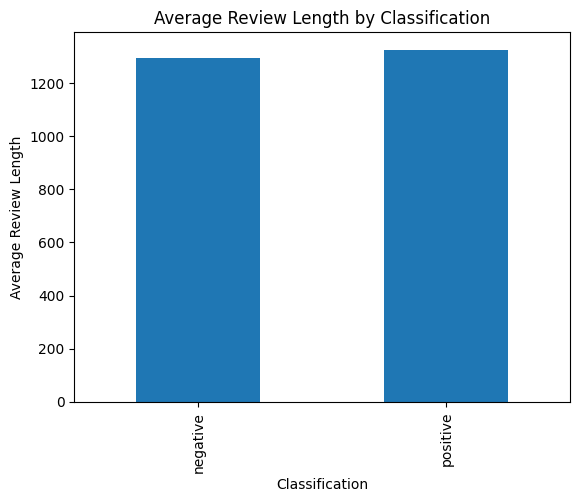

Average Review Length: 1309.43102
Longest Review Length: 13704
Shortest Review Length: 32
Number of Positive Reviews: 25000
Number of Negative Reviews: 25000


In [7]:
# TO BE COMPLETED

# 1. Calculate Average Character Length of a Review
df['review_length'] = df['review'].apply(len)
average_length = df['review_length'].mean()

# 2. Lengths of the Longest and Shortest Reviews
longest_review = df['review_length'].max()
shortest_review = df['review_length'].min()

# 3. Count Number of Positive and Negative Reviews
positive_reviews_count = df_pos.shape[0]
negative_reviews_count = df_neg.shape[0]

# 4. Histogram of Average Character Length for Positive and Negative Reviews
df.groupby('sentiment')['review_length'].mean().plot(kind='bar')
plt.xlabel('Classification')
plt.ylabel('Average Review Length')
plt.title('Average Review Length by Classification')
plt.show()

# Print the statistics
print(f"Average Review Length: {average_length}")
print(f"Longest Review Length: {longest_review}")
print(f"Shortest Review Length: {shortest_review}")
print(f"Number of Positive Reviews: {positive_reviews_count}")
print(f"Number of Negative Reviews: {negative_reviews_count}")


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

General observations :
Average Review Length: 1309.43102
Longest Review Length: 13704
Shortest Review Length: 32

The longest review length is significantly longer than the average review length,
being litteraly an order of magnitude longer. Having such a wide variation in
review length could mean that certain reviews contain more nuance, multiple themes,
or details irrespective of overall sentiment. These complexities could skew the
data if not handled properly.

Observations positive vs negative:
Number of Positive Reviews: 25000
Number of Negative Reviews: 25000

Dataset is therefore completely balanced between positive and negative reviews,
that said, the average number of characters per review is slightly larger in the
positive dataset.

This is good news for training, as the model shouldn't become biased towards one
sentiment or another due to the number of samples, or the relative sample sides.
These results indicate that people will write equally lengthy reviews, whether
they had a positive or negative experience with the film.

'''


### Part (iii) [1pt EXPLORATORY]

The following helper code will be used to process the data before we can train our LSTM model. In point form comment on what processing steps are performed in the code provided below and why these steps are necessary or beneficial to training and LSTM.

In [ ]:
X[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [8]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000]
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = [1 if label =='positive' else 0 for label in labels]

    return np.array(data_encoded), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

preprocess_string(str1):
- removes all non-word characters excluding number and letters
- removes all whitespaces
- replacs digits with no space

preprocess_sentence(sen1):
- takes a sentance as input, and loops through each word
- each word is preprocessed using 'preprocess_string' function
- if any word in the sentance isn't a stop word, it get's returned by the function

get_stoi(data):
- uses the preprocess_sentence function to get the word list for a full data entry.
- creates a counter which sorts the words based on into a dictionary based on frequency

tokenize(data, labels, stoi):
- tokenizes the dataset
- uses the stoi encoding by checking if each word in each entry of the dataset
  (gotten using preprocess_sentence) belongs to the stoi dictionary
- creates binary classification labels

padding_(sentences, seq_len)
- passes entries from a batch of reviews and pads each review with 0's based
  on the max sequence length (seq_length) from the reviews.
- returns padded reviews.

These helper functions aid in cleaning the data and selecting what words we'll
want to tokenize/pass into our model. General words from the stop word list are
essentially ignored, but special words which carry more semantic meaning to a sentance
are added to word lists. We use these word list to create a dictionary of words
used for tokenization, which is how we encode our words to pass to the model a
necessary step in any natural language processing. We also provide padding based
off an applied sequence length to our entries to account for the varrying length
of the reviews.

'''


"\nPROVIDE YOUR ANSWER BELOW\n\npreprocess_string(str1):\n- removes all non-word characters excluding number and letters\n- removes all whitespaces\n- replacs digits with no space\n\npreprocess_sentence(sen1):\n- takes a sentance as input, and loops through each word\n- each word is preprocessed using 'preprocess_string' function\n- if any word in the sentance isn't a stop word, it get's returned by the function\n\nget_stoi(data):\n- uses the preprocess_sentence function to get the word list for a full data entry.\n- creates a counter which sorts the words based on into a dictionary based on frequency\n\ntokenize(data, labels, stoi):\n- tokenizes the dataset\n- uses the stoi encoding by checking if each word in each entry of the dataset\n  (gotten using preprocess_sentence) belongs to the stoi dictionary\n- creates binary classification labels\n\npadding_(sentences, seq_len)\n- passes entries from a batch of reviews and pads each review with 0's based\n  on the max sequence length (seq

### Part (iv) [1pt EXPLORATORY]

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split. Then apply the above processing steps to prepare your data for training.

Set the padding of the reviews to 500.

In [9]:
# TO BE COMPLETED
random_state = 42

#split the data into training and temporary datasets with a 60/40 split.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_state)
# Then, split the temporary dataset equally into validation and test datasets to achieve a 20/20 split of the original.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

# create dictionary/encoder using the full dataset
stoi = get_stoi(X)

#tokenize data
X_train_encoded, y_train_encoded = tokenize(X_train, y_train, stoi)
X_val_encoded, y_val_encoded = tokenize(X_val, y_val, stoi)
X_test_encoded, y_test_encoded = tokenize(X_test, y_test, stoi)

#apply padding
max_padding = 500
X_train_encoded = padding_(X_train_encoded, max_padding)
X_val_encoded = padding_(X_val_encoded, max_padding)
X_test_encoded = padding_(X_test_encoded, max_padding)

<built-in method get of Counter object at 0x7d8d61784130>


<ipython-input-8-689f26062728>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


### Part (v) [1pt EXPLORATORY]

Create a DataLoader that will allow you to load the training and validation data in mini-batches. Then generate a dataset of batch size of 16 to verify that the DataLoader works as intended.

In [10]:
# TO BE COMPLETED

#convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_encoded)
y_train_tensor = torch.from_numpy(y_train_encoded)
X_val_tensor = torch.from_numpy(X_val_encoded)
y_val_tensor = torch.from_numpy(y_val_encoded)
X_test_tensor = torch.from_numpy(X_test_encoded)
y_test_tensor = torch.from_numpy(y_test_encoded)

# Create TensorDatasets for training and validation data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and validation data
# Set batch size
batch_size = 16

# Shuffle the training data to ensure random batch sampling
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Function to get a single batch from the DataLoader
def get_single_batch(data_loader):
    for batch in data_loader:
        # Return the first batch
        return batch

# Get a single batch to verify DataLoader works
train_batch = get_single_batch(train_loader)
val_batch = get_single_batch(val_loader)
test_batch = get_single_batch(train_loader)

# Print the size of the batched data and labels to verify
print(f"Train batch - features size: {train_batch[0].size()}, labels size: {train_batch[1].size()}")
print(f"Validation batch - features size: {val_batch[0].size()}, labels size: {val_batch[1].size()}")
print(f"Test batch - features size: {test_batch[0].size()}, labels size: {test_batch[1].size()}")


Train batch - features size: torch.Size([16, 500]), labels size: torch.Size([16])
Validation batch - features size: torch.Size([16, 500]), labels size: torch.Size([16])
Test batch - features size: torch.Size([16, 500]), labels size: torch.Size([16])


## Part 2. Model Building [2pt MODEL]

Build a recurrent neural network model, using an architecture of your choosing. Use one or more fully-connected layers to make the prediction based on your recurrent network output.

Instead of using the RNN output value for the final token, another often used strategy is to max-pool over the entire output array. That is, instead of calling something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs is one of the "hyperparameters" that you can choose to tune later on.

In [14]:
# TO BE COMPLETED

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Define embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Define LSTM layer(s)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # Define the final, fully-connected output layer
        # The input size is doubled because we concatenate max and mean pooling
        self.fc = nn.Linear(hidden_dim * 2, output_size)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        # Embedding and LSTM operations
        x = self.embedding(x)
        x, _ = self.lstm(x)

        # Pooling operations
        max_pool, _ = torch.max(x, dim=1)
        mean_pool = torch.mean(x, dim=1)
        # print(max_pool.shape)
        # print(mean_pool.shape)
        out = torch.cat((max_pool, mean_pool), 1)

        # Pass the pooled output to the fully connected layer
        out = self.fc(out)

        return out


## Part 3. Training [3 pt]

### Part (i) [1pt MODEL]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [24]:
from torch.cuda.amp import autocast
def get_accuracy(model, data, use_cuda = True):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """

    correct = 0
    total = 0
    for batch, labels in data:
      if use_cuda and torch.cuda.is_available() == True:
              batch = batch.cuda()
              labels = labels.cuda()
      # outputs = model(batch)
      # Get predictions using a threshold of 0.5
      with autocast():  # Enables mixed precision
          outputs = model(batch)
      pred = (torch.sigmoid(outputs) >= 0.5).float()
      # Compare with true labels and sum up the number of correct predictions
      correct += (pred.squeeze() == labels).sum().item()
      # Increment the total count
      total += labels.size(0)
    accuracy = correct/total
    return accuracy
    # TO BE COMPLETED



### Part (ii) [1pt MODEL]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [23]:
# TO BE COMPLETED
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

#Functions to save and load checkpoints
def save_checkpoint(model, optimizer, epoch, hyperparams, filename):
    checkpoint = {
        'epoch': epoch + 1,  # Saving the next epoch number
        'state_dict': model.state_dict(),
        'hyperparams': hyperparams,  # Add the hyperparameters
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    return checkpoint

def generate_checkpoint_filename(hyperparams, epoch):
    filename = f"{hyperparams['model_name']}_L{hyperparams['n_layers']}_H{hyperparams['hidden_dim']}_E{hyperparams['embedding_dim']}_LR{hyperparams['learning_rate']}_BS{hyperparams['batch_size']}_epoch{epoch}.pth"
    return filename

# Mostly from the sample code
def train_network(model, train_loader, valid_loader, hyperparams, num_epochs=5, learning_rate=1e-5, use_cuda = True):

    #Binary Classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    scaler = GradScaler()
    if use_cuda and torch.cuda.is_available() == True:
      model = model.cuda()

    for epoch in range(num_epochs):
        #Put model into training mode
        model.train()
        iter = 0

        #for training acc (not perfect, but more efficient than doing 2 forward passes)
        correct = 0
        total = 0

        for reviews, labels in tqdm(train_loader, desc = "Processing Batchs"):
            if use_cuda and torch.cuda.is_available() == True:
              reviews = reviews.cuda()
              labels = labels.cuda()
            # print(f"Iter {iter}")
            iter+=1
            optimizer.zero_grad()
            with autocast():  # Enables mixed precision
              pred = model(reviews)
              loss = criterion(pred.view(-1), labels.float())

            scaler.scale(loss).backward()  # Scales the loss
            scaler.step(optimizer)  # Optimizer step
            scaler.update()  # Updates the scale for next iteration


            # loss.backward()
            # optimizer.step()

            # Get predictions using a threshold of 0.5
            predictions = (torch.sigmoid(pred) >= 0.5).float()
            # Compare with true labels and sum up the number of correct predictions
            correct += (predictions.squeeze() == labels).sum().item()
            # Increment the total count
            total += labels.size(0)

        losses.append(float(loss))
        # if epoch % 5 == 4:
        epochs.append(epoch)
        #Put model into evaluation mode
        model.eval()
        with torch.no_grad():
          train_acc.append(correct/total)
          valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, loss, train_acc[-1], valid_acc[-1]))

        #Save checkpoint
        save_checkpoint(model, optimizer, epoch, hyperparams, generate_checkpoint_filename(hyperparams, epoch))

    # plotting
    plt.title("Training Curve - Loss")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve - Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0
Epoch 1; Loss 0.688338; Train Acc 0.499500; Val Acc 0.498900
Epoch 1
Epoch 2; Loss 0.695719; Train Acc 0.508800; Val Acc 0.507400
Epoch 2
Epoch 3; Loss 0.693153; Train Acc 0.537667; Val Acc 0.533600
Epoch 3
Epoch 4; Loss 0.690622; Train Acc 0.555867; Val Acc 0.553500
Epoch 4
Epoch 5; Loss 0.687316; Train Acc 0.571667; Val Acc 0.571700
Epoch 5
Epoch 6; Loss 0.688219; Train Acc 0.592000; Val Acc 0.591900
Epoch 6
Epoch 7; Loss 0.686559; Train Acc 0.609600; Val Acc 0.608400
Epoch 7
Epoch 8; Loss 0.683001; Train Acc 0.629500; Val Acc 0.624000
Epoch 8
Epoch 9; Loss 0.676627; Train Acc 0.640667; Val Acc 0.638000
Epoch 9
Epoch 10; Loss 0.677419; Train Acc 0.658867; Val Acc 0.655200
Epoch 10
Epoch 11; Loss 0.674712; Train Acc 0.672033; Val Acc 0.667800
Epoch 11
Epoch 12; Loss 0.684748; Train Acc 0.676700; Val Acc 0.677500
Epoch 12
Epoch 13; Loss 0.678622; Train Acc 0.693333; Val Acc 0.687400
Epoch 13
Epoch 14; Loss 0.659304; Train Acc 0.702833; Val Acc 0.697900
Epoch 14
Epoch 15; Loss 0

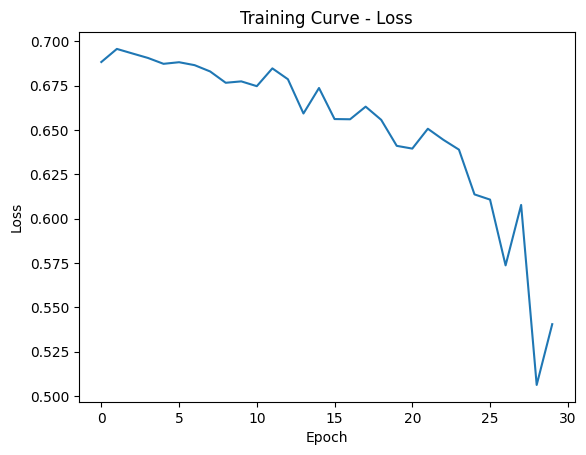

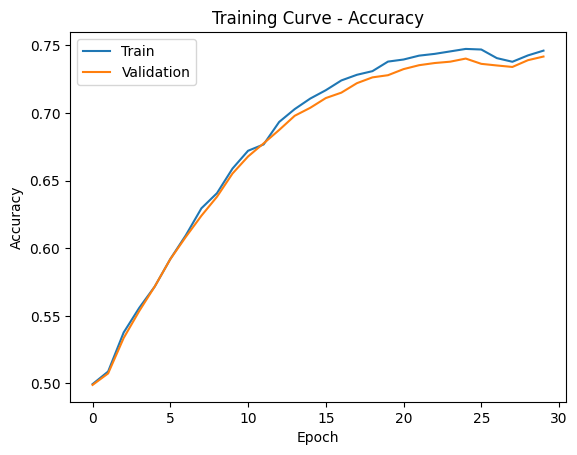

In [ ]:
vocab_size = len(stoi)+1  # Size of the vocabulary
output_size = 1    # Binary classification
embedding_dim = 128  # Size of the embeddings
hidden_dim = 128     # Size of the hidden layer in LSTMs
n_layers = 1         # Number of LSTM layers

model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

#increase batch for speed
batch_size = 256

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

num_epochs = 30
lr = 1e-5
train_network(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=lr)


### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Processing Batchs: 100%|██████████| 938/938 [00:26<00:00, 35.35it/s]


Epoch 1; Loss 0.646077; Train Acc 0.652667; Val Acc 0.724500


Processing Batchs: 100%|██████████| 938/938 [00:24<00:00, 37.55it/s]


Epoch 2; Loss 0.486523; Train Acc 0.746067; Val Acc 0.756600


Processing Batchs: 100%|██████████| 938/938 [00:24<00:00, 37.57it/s]


Epoch 3; Loss 0.315878; Train Acc 0.786267; Val Acc 0.783200


Processing Batchs: 100%|██████████| 938/938 [00:25<00:00, 37.15it/s]


Epoch 4; Loss 0.363234; Train Acc 0.811367; Val Acc 0.807800


Processing Batchs: 100%|██████████| 938/938 [00:24<00:00, 37.59it/s]


Epoch 5; Loss 0.434239; Train Acc 0.826167; Val Acc 0.815200


Processing Batchs: 100%|██████████| 938/938 [00:24<00:00, 37.62it/s]


Epoch 6; Loss 0.295583; Train Acc 0.836500; Val Acc 0.822200


Processing Batchs: 100%|██████████| 938/938 [00:25<00:00, 37.15it/s]


Epoch 7; Loss 0.407300; Train Acc 0.845200; Val Acc 0.829100


Processing Batchs: 100%|██████████| 938/938 [00:24<00:00, 37.61it/s]


Epoch 8; Loss 0.378222; Train Acc 0.850900; Val Acc 0.836600


Processing Batchs: 100%|██████████| 938/938 [00:24<00:00, 37.71it/s]


Epoch 9; Loss 0.313016; Train Acc 0.857267; Val Acc 0.836700


Processing Batchs: 100%|██████████| 938/938 [00:25<00:00, 37.35it/s]


Epoch 10; Loss 0.380240; Train Acc 0.861600; Val Acc 0.839700


Processing Batchs: 100%|██████████| 938/938 [00:25<00:00, 36.15it/s]


Epoch 11; Loss 0.497723; Train Acc 0.865567; Val Acc 0.841100


Processing Batchs: 100%|██████████| 938/938 [00:25<00:00, 37.21it/s]


Epoch 12; Loss 0.349528; Train Acc 0.870767; Val Acc 0.843500


Processing Batchs: 100%|██████████| 938/938 [00:24<00:00, 37.56it/s]


Epoch 13; Loss 0.369083; Train Acc 0.873400; Val Acc 0.845200


Processing Batchs: 100%|██████████| 938/938 [00:25<00:00, 37.47it/s]


Epoch 14; Loss 0.312343; Train Acc 0.875967; Val Acc 0.845400


Processing Batchs: 100%|██████████| 938/938 [00:27<00:00, 34.07it/s]


Epoch 15; Loss 0.254001; Train Acc 0.880100; Val Acc 0.842500


Processing Batchs: 100%|██████████| 938/938 [00:31<00:00, 30.19it/s]


Epoch 16; Loss 0.120554; Train Acc 0.881933; Val Acc 0.843200


Processing Batchs: 100%|██████████| 938/938 [00:26<00:00, 35.07it/s]


Epoch 17; Loss 0.193875; Train Acc 0.885500; Val Acc 0.839400


Processing Batchs: 100%|██████████| 938/938 [00:25<00:00, 37.49it/s]


Epoch 18; Loss 0.343240; Train Acc 0.889000; Val Acc 0.845800


Processing Batchs: 100%|██████████| 938/938 [00:28<00:00, 32.66it/s]


Epoch 19; Loss 0.333465; Train Acc 0.893867; Val Acc 0.845200


Processing Batchs: 100%|██████████| 938/938 [00:26<00:00, 35.08it/s]


Epoch 20; Loss 0.198247; Train Acc 0.894133; Val Acc 0.843700


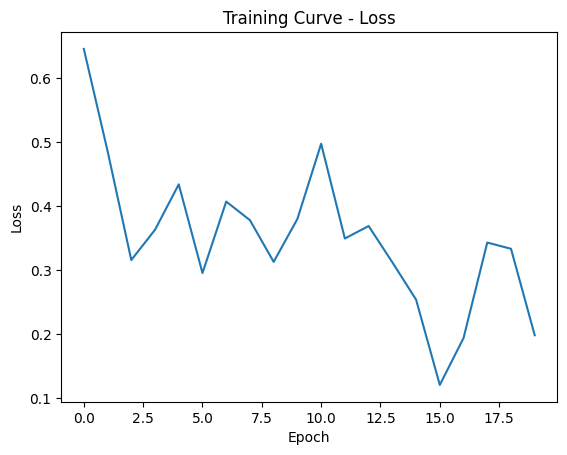

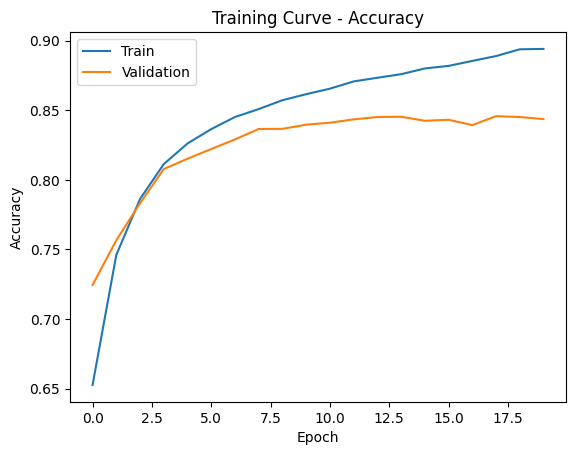

In [26]:
# TO BE COMPLETED
vocab_size = len(stoi)+1  # Size of the vocabulary
output_size = 1    # Binary classification
embedding_dim = 128  # Size of the embeddings
hidden_dim = 150     # Size of the hidden layer in LSTMs
n_layers = 1         # Number of LSTM layers

model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

#increase batch for speed
batch_size = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

num_epochs = 20
lr = 5e-5
#Hyperparameter dict just for saving later
hyperparams = {
'model_name': 'MyRNNModel',   # Replace with your model's name
'n_layers': n_layers,               # Number of LSTM layers
'hidden_dim': hidden_dim,           # Size of the hidden layer in LSTMs
'embedding_dim': embedding_dim,        # Size of the embeddings
'learning_rate': lr,      # Learning rate
'batch_size': batch_size             # Batch size
}

train_network(model, train_loader, val_loader, hyperparams, num_epochs=num_epochs, learning_rate=lr)


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

I decided to tune the learning rate, number of LSTM layers (started at 1), the
batch, and the hidden dimension.
The first variable I wanted to tune was the number of LSTM layers. Initially I
had only one, and still got a validation accuracy of 75%. Increasing to 2 or 3
effectively doubles or triples my network size, increasing memory demands and
computation time. For this reason, the learning rate was increased from 1e-5 to
1e-4 so that fewer iterations would be required for convergence. In reality, after
getting significantly better results with 2 layers, I tried 3, but quickly realized
that given time constraints it'd be hard to tune a model with 3 layers. So, instead,
I went back to using 1 or 2 layers and tuning the other hyperparameters first.

I soon realized that the same case could be made for the hidden layer. Doubling
it's dimension would massively increase network size, but to a great result aswell,
immediately adding 10% to validation and training accuracy, even with just 1 layer.

In the end my best result could be achieved using either 1 or 2 layers (used 1), and a
higher hidden dimmension at 150 instead of the initial 128. The model began
overfitting past epochs 16/18 for the layer 2 model, so the 11th epoch was taken
as the best at:

Training acc:   ~86.5%
Validation acc: ~84.1%


'''

## Part 4. Evaluation [10 pt]

**Important**. At this point in the assignment your test data should not have been evaluated by any of your models. The test data should be evaluated only after you have finished all the previous parts of the assignment. Once you evaluate your models on the test data you cannot change your models or else you may make hyperparameter adjustments that could lead to overfitting to the test data.

### Part (i) [3pt RESULT]

Report the final test accuracy of your model. Comment on how the result compares with accuracy obtained on the training and validation data. Are the results what you expected? Explain.

In [ ]:
# TO BE COMPLETED
output_size = 1    # Binary classification
embedding_dim = 128  # Size of the embeddings
hidden_dim = 150     # Size of the hidden layer in LSTMs
n_layers = 2         # Number of LSTM layers
use_cuda = True

model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
# Load Best Model:
checkpoint = load_checkpoint('/content/MyRNNModel_L2_H150_E128_LR6e-05_BS256_epoch20.pth')
model.load_state_dict(checkpoint['state_dict'])

if use_cuda and torch.cuda.is_available() == True:
      model = model.cuda()

batch_size = 16
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

test_accuracy = get_accuracy(model,test_loader)
print(f"Test Accuracy: {test_accuracy}")


Test Accuracy: 0.8397


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

We would expect that since we tuned the model parameters on the training data,
then we tuned the hyperparameters to maximize the validation data accuracy without
overfitting, both of those would be higher than the test data, which is a
generalized abstraction from the validation and training data. This is exactly
what we see. Where before our optimizer was able to tune our model parameters
to roughly 86% accuracy, and we tuned our model architecture/hyperparameters to
achieve roughly 84% accuracy, when testing on the tet set we achieve an accuracy
of 83.97%, which is just below our validation accuracy. With this, the results
are as expected.



'''


### Part (ii) [3pt DISCUSSION]

Look over the misclassified samples in the test data and see if you can find any patterns on where the model has difficulty with identifying the review sentiment. Provide up to 5 examples of positive and negative reviews each to support your findings.

In [ ]:
# TO BE COMPLETED

def print_incorrect_classifications(model, data_loader, X_test, y_test, max_prints=10):
    """ Print indices of incorrectly classified reviews from X_test """
    model.eval()
    false_pos = 0
    false_neg = 0
    total_idx = 0  # Keep track of the global index across batches

    with torch.no_grad():
        for inputs, labels in data_loader:
            if use_cuda and torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities >= 0.5).float()

            # Find which predictions are incorrect
            incorrects = (predictions.squeeze() != labels)
            incorrect_indices = incorrects.nonzero(as_tuple=False).squeeze()

            for idx in incorrect_indices:
                global_idx = total_idx + idx.item()
                #Break Condition
                if false_neg >= max_prints and false_pos >= max_prints:
                  return

                # print false positive review
                elif false_neg < max_prints and y_test[global_idx] == 'negative':
                  print(f"Incorrectly Classified Review Index: {global_idx}")
                  print(f"Review: {X_test[global_idx]}")
                  print(f"Predicted: Positive, Actual: Negative\n")
                  false_neg +=1

                # print false negative review
                elif false_pos < max_prints and y_test[global_idx] == 'positive':
                  print(f"Incorrectly Classified Review Index: {global_idx}")
                  print(f"Review: {X_test[global_idx]}")
                  print(f"Predicted: Negative, Actual: Positive\n")
                  false_pos += 1

            total_idx += inputs.size(0)

# Create test DataLoader without shuffling, so indices are conserved
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

# Call the function
print_incorrect_classifications(model, test_loader, X_test, y_test, max_prints=5)



Incorrectly Classified Review Index: 48
Review: While watching the film, I'm not sure what direstion it was to take. There's a reason a writer shouldn't direct his work and even act in it as well, you can't do it all. I felt the story really suffered in this film due to the director wearing so many hats. Ms. McTeer is the film. To add to her amazing talents, her portrayal of this woman was why I was engaged. Here is a British actress who can do anything. In my view, conflict is what makes drama and a great story. I felt this film didn't have that. Everything was somewhat easy for the characters, there were no real obstacles preventing the chahracters from getting what they wanted. Watch the film for the sweetness, but most of all for Ms. McTeer's brilliant performance.
Predicted: Positive, Actual: Negative

Incorrectly Classified Review Index: 54
Review: You could see the final outcome from a mile away.All the signs were there....the prom,the liquor,the fast ride,the distraction of the

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Generally speaking, the incorrect classification seem to be due to the use of
positive or reinforcing adjectives during negative reviews, and negative adjectives
during positive reviews. Essentialy the language used and the structure of the
review requires more semantic understanding and depth to grasp the writer's actual
feelings. A good exmaple is in review indes 54 (second printed result above) in
which phrases such as:
"A good commercial for seatbelt usage"
"Leaving the dance for a joyride"
Which imply positive connotations, but are used in the context of criticism.

Another good example is review index 90, which was a false negative classification.
In this review, the user mentions the phrase 'bad guys' or 'very bad guys', or
'bad crowd' like 4 times! Just the semantic meaning of individual words repeated
over and over is enough to change the classification. The model isn't capabale of
understanding that the user is quoting the film and describing
the scenario with these terms, rather than only stating their opinion.

One more example: review index 128, the last printed review, used all the following
words or phrases:
"brains get messed together"
"Bruce Campbell beating himself up"
"simplistic movies"
"want to see weird movies"
"it's going to border that completely silly type of movie"
"with more silly and less monsters"
"Bruce gets bad things happen to him"
"Ted Raimi as a weird Russian guy"
"Never a point of scary"
AND:
"why would you be watching this if you didn't like Bruce Campbell?"

Need I say more as to why the model won't predict this review correctly? it's a
very confusing review if you don't dig into the context that the user LIKES silly,
weird, simplistic, movies that make them laugh.
'''


### Part (iii) [2pt RESULT]

What is your model's prediction of the **probability** that
the review message provided below is a positive review?

Hint: You will need to apply the same processing on the review as was done on the the train, val, and test data sets.

In [ ]:
review = """ Man.... I wish I loved this movie more than I did. Don't get me wrong,
it's a solid action movie with jaw-dropping stunts (some of the best in the series),
but as a Mission: Impossible movie, it felt like a small step backward for the franchise.
Fallout had mind-blowing action sequences and stunt work, along with developing Ethan's
relationship with Ilsa, providing closure with Julia, showing the lengths Ethan would
go to protect those closest to him, and battling an imposing villain. Dead Reckoning:
Part One stretches the movie across two films only to seemingly showcase action
spectacle after action spectacle while sacrificing character development.
Characters I have grown to love over a decade of films felt sidelined, ignored,
or wasted. Hayley Atwell's new character chewed up most of the screen time, and
while she was fantastic, I wanted to see more of the original team. The new villain
had an inconsistent ability that confused more than intimidated. There were some
important emotional moments that I just didn't feel the weight of when I definitely
should have. Part Two might tie everything together and make me enjoy Part One
more in retrospect, but unfortunately, I left wanting more from this one. """



In [ ]:
# TO BE COMPLETED

# Preprocess:
def make_single_prediction(review, model, use_cuda = True):

  sample_encoded, y_sample_encoded = tokenize(np.array([review]), np.zeros(1), stoi) #negative review I think
  #apply padding
  max_padding = 500
  sample_encoded = padding_(sample_encoded, max_padding)
  #turn into pytorch tensor
  sample_tensor = torch.from_numpy(sample_encoded)
  #use gpu if available
  if use_cuda and torch.cuda.is_available():
    model = model.cuda()
    sample_tensor = sample_tensor.cuda()
  #get prediction from model
  with torch.no_grad():
    model.eval()
    pred = model(sample_tensor)
    probability = torch.sigmoid(pred)
    # prediction = (torch.sigmoid(pred) >= 0.5).float()
  return probability.item()

# Make a prediction and get the probability
probability = make_single_prediction(review, model)
print("Probability of being positive:", probability)



Probability of being positive: 0.7228659391403198


### Part (iv) [2pt DISCUSSION]

Do you think that detecting positive and negative reviews is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

I think that detecting the sentiment of a review is a difficult task. The truth
is that unless the review is constrained so some straightforward writing style,
length, or content, a review can be as nuanced and complicated as any other piece
of writing. For this reason, the act of classifying it into 2 categories, positive
or negative, perfectly would require a network to learn and understand the purpose
and unique perspectives hidden within the language just like a human. It's not
enough to associate some words, a model needs to be able to extract context in
a variety of environments and sentance structures. The way in which meaning
is communicated in natural language can take many forms, and even one small mistake
in how a sentance is put together can completely change it's meaning. All it takes
is the placement of one comma, or hypostrephe, and a sentances meaning is altered.

If I were to build a very simple baseline model, I would probably do away with
attempting to develop an understanding of sequence or context, and rather just
look at word association. We could have 2 dictionaries: one with positive connotation,
and one with negative connotation. Then we could perform a scrape across the review
to get words which match between the 2 dictionaries. We could also apply weights
to different words, say having the word 'great' be worth more than the word 'good'
for the positive connotation dictionary. So, we scrape the review, see which words
match between the review and either dictionary, and tally up the scores to see whether
the review has more words associated with the positive or negative vocabs.This is
a pretty terrible approach, because any positive review which talks about a scary
or harsh film (like horrors or thrillers) will probably use words with negative
connotation when describing the content of the film itself, even if the review
of said film is positive, and same vice versa for feel good films which actually
weren't reviewed well.

That said, it would provide a baseline for assessing sentiment.


'''

# PART B - Transfer Learning

For many natural language processing tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to enormous compute requirements and lack of sufficient amounts of training data. Instead, you should always try to take advantage of an existing model that performs similar tasks as the one you need to solve.

In this part of the assignment we will be using pretrained models to improve the performance on identifying positive and negative reviews. There are several pretrained models that are available to us, here we will use a pretrained BERT model that comes with the hugging face transformer library.

Provided below is sample code to get you started. For more details please visit the hugging face tutorial on using pretrained models using PyTorch: https://huggingface.co/docs/transformers/training

#### Sample Code

In [29]:
# install relevant libraries
!pip install -qq transformers

In [30]:
# load relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
encoding['input_ids']

tensor([[  101,   146,  1328,  1106,  3858,  1293,  1106,  1202, 17024,  3622,
          1606,   139,  9637,  1942,  1105, 22559, 17260,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]

In [ ]:
hidden_size = bert_model.config.hidden_size

print(hidden_size)
print(hidden_states.shape)
print(pooled_output.shape)


768
torch.Size([1, 32, 768])
torch.Size([1, 768])


In the sample code provided we loaded a short text sequence, tokenized it using the same tokenization that was used in the pretrained BERT model, and fed the tokenized input into the BERT model to obtain the embeddings.

The model output consists of two forms of embeddings:
- **hidden_states** are the final layer of outputs that has a shape sequence_length x embeddings, much like the hidden states of a recurrent neural network
- **pooled_output** is the result of applying max pooling on the hidden states to effectively collapse the sequence dimenension and ensure the same output size for any given sequence before feeding into the classification stage

Note that you can preprocess all of the data prior to training a classifier stage for sentiment analysis to help speed up the training process. This is no different from the process we applied in an earlier assignment using AlexNet and image data.

## Part 1. Data Loading [5 pt]

We will be using the same "IMDB Movie Review Dataset" that we used earlier. Reload the data and complete Part B of the assignment. You should be able to complete part B independently from Part A.

### Part (i) [1pt EXPLORATORY]

Provided below is a DataLoader for your training and test datasets so you can iterate over batches of data. Run the DataLoader to create your training, validation, and test data.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader

In [28]:
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [39]:
# prepare data loaders
MAX_LEN = 400
BATCH_SIZE = 16
NUM_WORKERS = 4
random_state = 42

# Using my prexisting X_train, X_val, X_test numpy arrays from part 1.
# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values
#Change targets to integer boolean rather than string:
for i in range(len(y)):
  if y[i] == 'positive':
    y[i] = 1
  else:
    y[i] = 0
#split the data into training and temporary datasets with a 60/40 split.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_state)
# Then, split the temporary dataset equally into validation and test datasets to achieve a 20/20 split of the original.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

#training data
train_data = MovieReviewDataset(reviews=X_train,
                                targets=y_train,
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS) #modify num_works as needed

#validation data
# TO BE COMPLETED
validation_data = MovieReviewDataset(reviews=X_val,
                                targets=y_val,
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

validation_data_loader = DataLoader(validation_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS) #modify num_works as needed
#test data
# TO BE COMPLETED
test_data = MovieReviewDataset(reviews=X_test,
                                targets=y_test,
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

test_data_loader = DataLoader(test_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS) #modify num_works as needed


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Part (ii) [1pt EXPLORATORY]

Use the **train_data_loader** to load one sample. What are the different attributes provided with the sample and how are they used?

In [ ]:
# TO BE COMPLETED
# Function to get a single batch from the DataLoader
for batch in train_data_loader:
    break

sample_input_ids = batch['input_ids'][0]  # Get the input_ids of the first sample in the batch
sample_attention_mask = batch['attention_mask'][0]  # Get the attention_mask of the first sample in the batch
sample_target = batch['targets'][0]  # Get the target label of the first sample in the batch
sample_review_text = batch['review_text'][0]  # Get the review text of the first sample in the batch

# If you need to, you can convert these to the appropriate format (e.g., numpy array, list, etc.)
# For example, converting tensors to numpy arrays (if needed):
sample_input_ids = sample_input_ids.numpy()
sample_attention_mask = sample_attention_mask.numpy()
sample_target = sample_target.item()  # For a single value, you can use .item() to get it as a Python scalar

# Now you can use these samples as needed
print("Sample Input IDs:", sample_input_ids)
print("Sample Attention Mask:", sample_attention_mask)
print("Sample Target:", sample_target)
print("Sample Review Text:", sample_review_text)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Sample Input IDs: [  101   146 12214   113  2776  5847   114  1641  1121  1199  1168  7368
   119   146  1138  1106  1474   117  1115  1112   178  1932  1274   112
   189  1176  2398  1326   117   146  1541  1225  3851  1142  1141   119
  2038  2650   117  5426  1105  1136   172 16879  2744  1642   117  1363
  3176   117  1363  1105  1254  1136   172 16879  2744   113  1134  1107
  1692  1104 17693  8032  1116  1110  1897  4054   114 17693  8032  1116
   119   119   119  1135  1110  1541  5426   117  1293  1103  2650  2771
 10843  1114  1296  1168   117  1105  2121  3650  1193   117  2121  1167
  1137  1750  1120  7091  2933  1296  1639  2491   119  1252 16679   117
  1112  1195  1474  1107  1412  1583   118  1202  1128  1221  1293  1202
  1128  6239   170  1363  1646  1326   136  1135  1110  1103  1141  1115
  1400 13825  1196  1103  1322  1104  1103  1148  1265   119  6542   117
  1122  2762   112   189  1579  2276   117  1133   119   119   119   102
     0     0     0     0     0   

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Input ID's are just the tokenized version of the sample input using the BERT tokenizer.
A tokenizer is necessary for mapping a string input to a word ID before embedding.

The attention mask is a binary list indicating which ID's need attention from the
modelm and which are padding.

The target is obviously the classification, and is required for training and validation.

Finally the sample review text is the input to the tokenizer, the raw data itself.

'''

### Part (iii) [1pt EXPLORATORY]

Determine the range of values for the tokens in the training data. How are the tokens obtained?

Hint: You can apply your intuition here, or do some additional research to find how the "bert-base-cased" tokenization is done.

In [ ]:
# TO BE COMPLETED

num_unique_tokens = len(tokenizer.vocab)
print("Number of unique tokens in tokenizer:", num_unique_tokens)

Number of unique tokens in tokenizer: 28996


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW


So the bert base model cased loaded from hugging face has about 29000 unique tokens.
From research, it looks like the bert tokenizer uses a wordpiece algorithm to
create it's vocabulary, where if it encounters an unknown word it can split
it into subwords to derive some semantic meaning. Additionaly, bert-CASED refers
to the model's distinction between using uppercase vs lowercase letters. Bert-cased
has a larger vocabulary because it distinguishes some difference in meaning between
capitalizaed or non capitalized letters. IE. Sky (the nickname) or sky (the environment)
for example


'''

### Part (iv) [1pt EXPLORATORY]

Generate histograms of all the token values in the training data. Repeat for the validation and test data. What are the top 5 occuring tokens in the training_dataset? What do these tokens represent?

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Top 5 tokens in the training dataset:
Token ID: 0, Token: [PAD], Frequency: 4297970
Token ID: 119, Token: ., Frequency: 318233
Token ID: 1103, Token: the, Frequency: 276129
Token ID: 117, Token: ,, Frequency: 258629
Token ID: 170, Token: a, Frequency: 153457


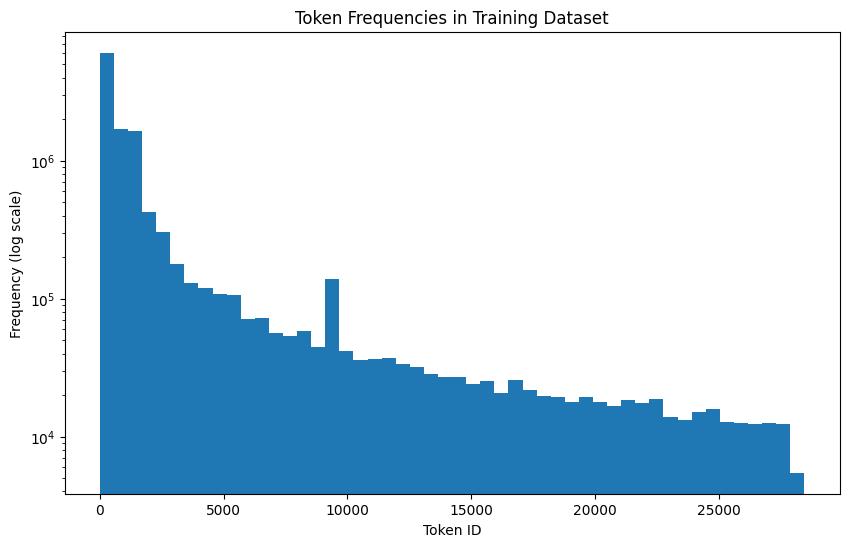

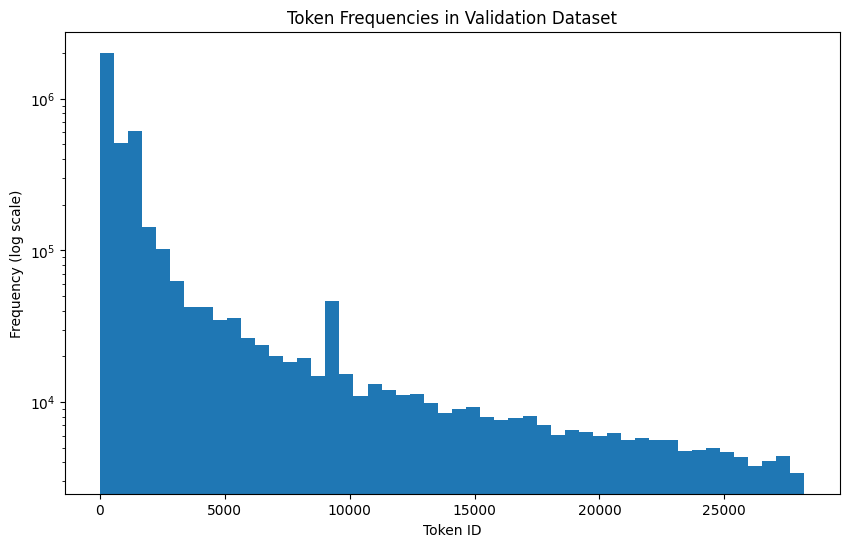

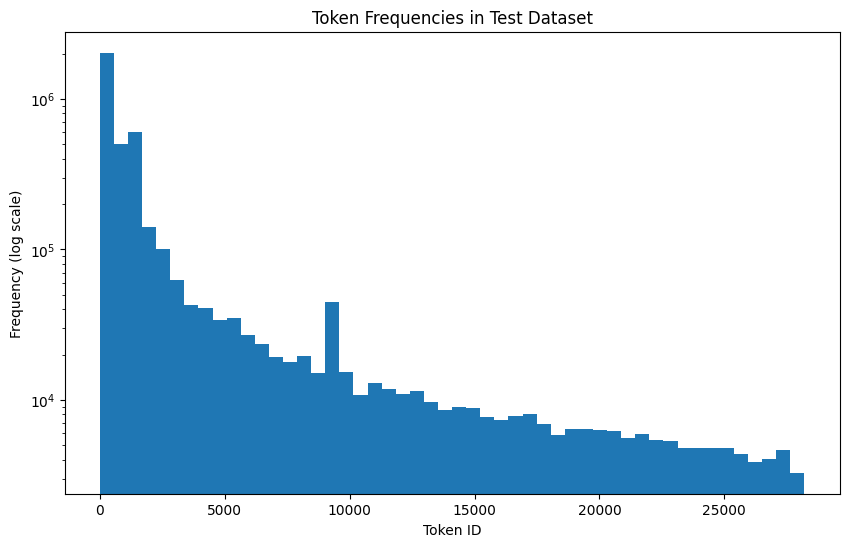

In [ ]:
# TO BE COMPLETED
from collections import Counter

def count_tokens_dataloader(data_loader):
    token_counter = Counter()
    for batch in data_loader:
        input_ids = batch['input_ids']
        for ids in input_ids:
            token_counter.update(ids.tolist())
    return token_counter

# Count tokens using DataLoaders
train_token_counts = count_tokens_dataloader(train_data_loader)
val_token_counts = count_tokens_dataloader(validation_data_loader)
test_token_counts = count_tokens_dataloader(test_data_loader)

#identify top 5 tokens in the training dataset
top_5_tokens = train_token_counts.most_common(5)
print("Top 5 tokens in the training dataset:")
for token, freq in top_5_tokens:
    print(f"Token ID: {token}, Token: {tokenizer.decode([token])}, Frequency: {freq}")


def plot_histogram(token_counts, title):
    plt.figure(figsize=(10, 6))
    plt.hist(token_counts.keys(), bins=50, weights=list(token_counts.values()), log=True)
    plt.xlabel('Token ID')
    plt.ylabel('Frequency (log scale)')
    plt.title(title)
    plt.show()

# Plot histograms for each dataset
plot_histogram(train_token_counts, "Token Frequencies in Training Dataset")
plot_histogram(val_token_counts, "Token Frequencies in Validation Dataset")
plot_histogram(test_token_counts, "Token Frequencies in Test Dataset")


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Top 5 tokens in the training dataset are:
Token ID: 0, Token: [PAD], Frequency: 4297970
Token ID: 119, Token: ., Frequency: 318233
Token ID: 1103, Token: the, Frequency: 276129
Token ID: 117, Token: ,, Frequency: 258629
Token ID: 170, Token: a, Frequency: 153457

So the most common tokens are padding, periods, the word 'the', commas,
and the word 'a'. This makes some good sense to be honest.


'''

### Part (v) [1pt EXPLORATORY]

Select a single sample from your training DataLoader and feed it through the **bert_model** to obtain the hidden_states and pooled_output. Briefly describe what each tensor dimension represents and what affects the size of each dimension.

In [ ]:
# TO BE COMPLETED

# Get first batch:
for batch in train_data_loader:
    input_ids = batch['input_ids'][0]
    att_mask = batch['attention_mask'][0]
    break
input_ids = input_ids.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)

hidden_states_and_pooled_out = bert_model(input_ids=input_ids,
                           attention_mask=att_mask)
hidden_states = hidden_states_and_pooled_out[0]
pooled_outs = hidden_states_and_pooled_out[1]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

In [ ]:
print("HIDDEN STATES: \n", hidden_states.shape)
print("POOLED OUTPUTS: \n", pooled_outs.shape)

HIDDEN STATES: 
 torch.Size([1, 400, 768])
POOLED OUTPUTS: 
 torch.Size([1, 768])


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

The first dimension for either tensor represents the batch size. In this case
since we're only feeding a single sample into the model it is 1.

The second dimension of the hidden states represents the sequence length, which
can be toggled. The pooled outputs have been pooled across this second dimension,
then squeezed, so it does not have this sequency length dimension.

The third dimension (second for pooled outputs) is the hidden dimension, or the
encoding dimension of the output. This is 768 above, and it represents the number
of variables we're using to represent the single imbedded output.


'''

## Part 2. Model Architecture [2 pt]

### Part (i) [1pt MODEL]

Prepare a review classifier model that builds on the pooled output from the Bert model to identify positive and negative reviews.

In [34]:
class SentimentClassifierPooled(nn.Module):

  def __init__(self, n_classes = 1, drop = 0.3):
    super(SentimentClassifierPooled, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    # Freeze BERT parameters
    for param in self.bert.parameters():
      param.requires_grad = False

    # TO BE COMPLETED
    #add dropout layer
    self.drop = nn.Dropout(p=drop)
    #fully connected layer
    self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]
    # TO BE COMPLETED
    dropped_output = self.drop(pooled_output)
    # print("Dropped output shape:", dropped_output.shape)
    out = self.fc(dropped_output)
    return out


### Part (ii) [1pt MODEL]

Construct the architecture for a review classifier model that uses the last hidden output from the Bert model to identify positive and negative reviews.

In [33]:
class SentimentClassifierLast(nn.Module):

  def __init__(self, max_tokens, n_classes = 1, drop = 0.3):
    super(SentimentClassifierLast, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    # Freeze BERT parameters!!!
    for param in self.bert.parameters():
      param.requires_grad = False

    # TO BE COMPLETED
    #I'm going to try using a weighted average sum for the classification.
    self.sequence_length = max_tokens
    #weighted sum layer
    self.weights = nn.Parameter(torch.ones(self.sequence_length) / self.sequence_length)
    #dropout layer
    self.drop = nn.Dropout(p=drop)
    #final linear layer
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    # TO BE COMPLETED
    hidden_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]

    # Apply weighted average summation
    weighted_sum = torch.einsum('blh,l->bh', hidden_output, self.weights)

    # Apply dropout to the summation
    dropped_output = self.drop(weighted_sum)

    # Pass through the output classification layer
    output = self.out(dropped_output)

    return output


In [32]:
class SentimentClassifierLast2(nn.Module):

  def __init__(self, max_tokens, n_classes = 1, drop = 0.3):
    super(SentimentClassifierLast2, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    # Freeze BERT parameters!!!
    for param in self.bert.parameters():
      param.requires_grad = False

    # TO BE COMPLETED
    #I'm going to try using a weighted average sum for the classification.
    self.sequence_length = max_tokens
    #weighted sum layer
    self.weights = nn.Parameter(torch.ones(self.sequence_length) / self.sequence_length)
    #dropout layer
    self.drop = nn.Dropout(p=drop)
    self.bingus = nn.Linear(self.bert.config.hidden_size, 100)
    #final linear layer
    self.out = nn.Linear(100, n_classes)

  def forward(self, input_ids, attention_mask):

    # TO BE COMPLETED
    hidden_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]

    # Apply weighted average summation
    weighted_sum = torch.einsum('blh,l->bh', hidden_output, self.weights)

    # Apply dropout to the summation
    dropped_output = self.drop(weighted_sum)

    # Pass through the output classification layer
    output1 = self.bingus(dropped_output)
    output2 = self.out(output1)

    return output2


## Part 3. Training [3 pt]

### Part (i) [1pt MODEL]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [35]:
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

def get_accuracy(model, data, use_cuda = True):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    if use_cuda and torch.cuda.is_available() == True:
      model = model.cuda()

    with torch.no_grad():  # Disable gradient computation
      for batch in tqdm(data, desc = "Getting Accuracy..."):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['targets']

        if use_cuda and torch.cuda.is_available() == True:
          input_ids = input_ids.cuda()
          attention_mask = attention_mask.cuda()
          labels = labels.cuda()

        with autocast():  # Enables mixed precision
          pred = model(input_ids, attention_mask).squeeze(-1)

        # outputs = model(input_ids, attention_mask).squeeze() # transform shape from [batch_size, 1] to [batch_size]
        prediction = (torch.sigmoid(pred) >= 0.5).float()
        # Compare with true labels and sum up the number of correct predictions
        correct += (prediction == labels).sum().item()
        # Increment the total count
        total += labels.size(0)
    return correct/total

    # TO BE COMPLETED


### Part (ii) [1pt MODEL]

Write a function **train_model** to train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [ ]:
# TO BE COMPLETED
from torch.cuda.amp import GradScaler, autocast

#Functions to save and load checkpoints
def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        'epoch': epoch + 1,  # Saving the next epoch number
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return checkpoint['epoch']

def generate_checkpoint_filename(epoch):
    filename = f"bert_model_epoch{epoch}.pth"
    return filename

# Mostly from the sample code
def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5, use_cuda = True):
    scaler = GradScaler()
    #Binary Classification
    criterion = nn.BCEWithLogitsLoss()
    # move to gpu
    if use_cuda and torch.cuda.is_available():
        model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    for epoch in range(num_epochs):
        print(f"epoch: {epoch}")
        #Put model into training mode
        model.train()
        iter = 0
        #for training acc (not perfect, but more efficient than doing 2 forward passes)
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc="Processing batches"):
            # if iter%100 == 0:
            #   print(f"iteration: {iter}")

            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['targets']

            if use_cuda and torch.cuda.is_available() == True:
              input_ids = input_ids.cuda()
              attention_mask = attention_mask.cuda()
              labels = labels.cuda()

            optimizer.zero_grad()
            with autocast():  # Enables mixed precision
              pred = model(input_ids, attention_mask).squeeze(-1)
              loss = criterion(pred, labels.float())

            scaler.scale(loss).backward()  # Scales the loss
            scaler.step(optimizer)  # Optimizer step
            scaler.update()  # Updates the scale for next iteration
            # pred = model(input_ids, attention_mask).squeeze(-1)
            # loss = criterion(pred, labels.float())
            # loss.backward()
            # optimizer.step()

            # Get predictions using a threshold of 0.5
            predictions = (torch.sigmoid(pred) >= 0.5).float()
            # Compare with true labels and sum up the number of correct predictions
            correct += (predictions == labels).sum().item()
            # Increment the total count
            total += labels.size(0)
            iter += 1

        losses.append(float(loss))
        epochs.append(epoch)
        #Put model into evaluation mode
        model.eval()
        with torch.no_grad():
          train_acc.append(correct/total)
          valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, loss, train_acc[-1], valid_acc[-1]))
        #Save checkpoint
        save_checkpoint(model, optimizer, epoch, generate_checkpoint_filename(epoch))
        #clear cache
        if use_cuda and torch.cuda.is_available():
          torch.cuda.empty_cache()
    # plotting
    plt.title("Training Curve - Loss")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve - Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters. You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 0


Getting Accuracy...: 100%|██████████| 625/625 [01:37<00:00,  6.40it/s]


Epoch 1; Loss 0.289006; Train Acc 0.733667; Val Acc 0.829500
epoch: 1


Getting Accuracy...: 100%|██████████| 625/625 [01:33<00:00,  6.67it/s]


Epoch 2; Loss 0.359795; Train Acc 0.814633; Val Acc 0.842500
epoch: 2


Getting Accuracy...: 100%|██████████| 625/625 [01:33<00:00,  6.66it/s]


Epoch 3; Loss 0.263504; Train Acc 0.825800; Val Acc 0.849100
epoch: 3


Getting Accuracy...: 100%|██████████| 625/625 [01:32<00:00,  6.74it/s]


Epoch 4; Loss 0.415410; Train Acc 0.829367; Val Acc 0.851900
epoch: 4


Getting Accuracy...: 100%|██████████| 625/625 [01:33<00:00,  6.70it/s]


Epoch 5; Loss 0.346246; Train Acc 0.831900; Val Acc 0.852800


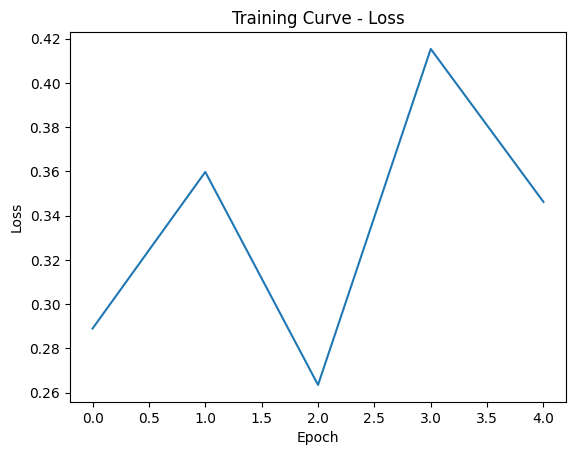

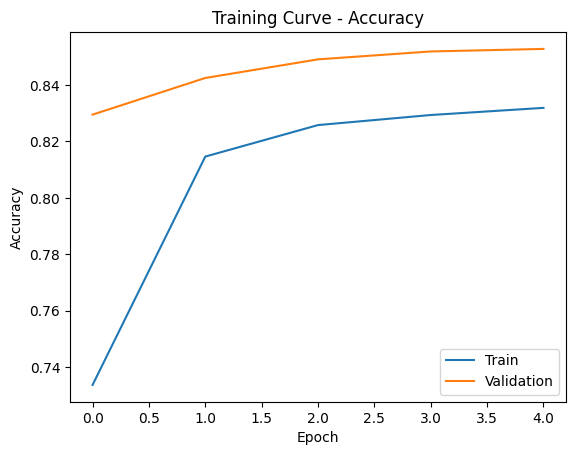

In [ ]:
# filter out deprecation warnings (because I live on the edge)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")

output_size = 1    # Binary classification
max_tokens = 400
model = SentimentClassifierLast(max_tokens, n_classes = output_size)
# model = SentimentClassifierPooled(n_classes = output_size)
#increase batch for speed
batch_size = 16

train_data_loader = DataLoader(train_data, batch_size = batch_size, num_workers = 4) #modify num_works as needed
val_data_loader = DataLoader(validation_data, batch_size = batch_size, num_workers = 4) #modify num_works as needed

num_epochs = 5
lr = 5e-5
train_network(model, train_data_loader, val_data_loader, num_epochs=num_epochs, learning_rate=lr)


epoch: 0


Getting Accuracy...: 100%|██████████| 1000/1000 [01:45<00:00,  9.44it/s]


Epoch 1; Loss 0.401308; Train Acc 0.794733; Val Acc 0.849300
epoch: 1


Getting Accuracy...: 100%|██████████| 1000/1000 [01:37<00:00, 10.27it/s]


Epoch 2; Loss 0.488933; Train Acc 0.836367; Val Acc 0.856000
epoch: 2


Getting Accuracy...: 100%|██████████| 1000/1000 [01:38<00:00, 10.20it/s]


Epoch 3; Loss 0.292136; Train Acc 0.844400; Val Acc 0.858900
epoch: 3


Getting Accuracy...: 100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]


Epoch 4; Loss 0.362564; Train Acc 0.847167; Val Acc 0.860600
epoch: 4


Getting Accuracy...: 100%|██████████| 1000/1000 [01:37<00:00, 10.22it/s]


Epoch 5; Loss 0.238996; Train Acc 0.850833; Val Acc 0.860800


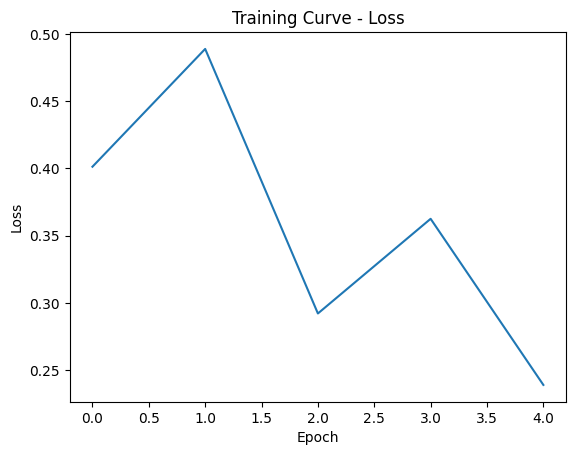

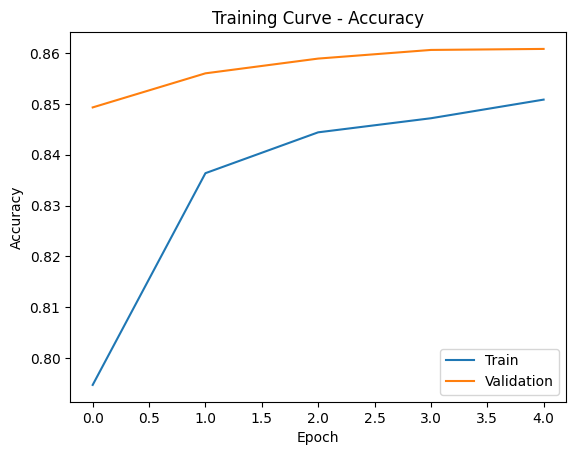

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")

output_size = 1    # Binary classification
max_tokens = 400
model = SentimentClassifierLast(max_tokens, n_classes = output_size, drop = 0.2)
# model = SentimentClassifierPooled(n_classes = output_size)
#increase batch for speed
batch_size = 10

train_data_loader = DataLoader(train_data, batch_size = batch_size, num_workers = 2) #modify num_works as needed
val_data_loader = DataLoader(validation_data, batch_size = batch_size, num_workers = 2) #modify num_works as needed

num_epochs = 5
lr = 1e-4
train_network(model, train_data_loader, val_data_loader, num_epochs=num_epochs, learning_rate=lr)

In [ ]:
output_size = 1    # Binary classification
max_tokens = 400
model = SentimentClassifierPooled(n_classes = output_size)
# model = SentimentClassifierPooled(n_classes = output_size)
#increase batch for speed
batch_size = 16

train_data_loader = DataLoader(train_data, batch_size = batch_size, num_workers = 2) #modify num_works as needed
val_data_loader = DataLoader(validation_data, batch_size = batch_size, num_workers = 2) #modify num_works as needed

num_epochs = 5
lr = 1e-4
train_network(model, train_data_loader, val_data_loader, num_epochs=num_epochs, learning_rate=lr)
# Damn that worked terribly.

epoch: 0


Getting Accuracy...: 100%|██████████| 625/625 [01:34<00:00,  6.64it/s]


Epoch 1; Loss 0.621990; Train Acc 0.571333; Val Acc 0.654200
epoch: 1


Processing batches:  35%|███▍      | 648/1875 [01:47<03:23,  6.04it/s]


KeyboardInterrupt: ignored

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Firstly, it's worth noting that the calculation of my training
accuracy is slightly misleading. In the training loop I count up
the correct predictions while the weights are being adjusted during each epoch
rather than all at the end. This is for computational efficiency and memory
purposes, as using the 'get_accuracy' function on the training data would require
looping through and forward passing all (30000 samples) of the training data for a second time.
Instead of that, I need to save on memory and time for this assignment, since
training is already taking forever. Because I'm calculating the training accuracy
while updating weights, the final accuracy is a mix of predictions from the
beggining and end of (this fairly long) epoch, so it will be lower than the
final training accuracy at the end of the epoch. Even worse: I'm using dropout,
so while calculating the training accuracy in the loop I'm not even using all the
weights. I acknowledge and accept this, simply because training is taking too long
and after exhausting all my options, I have to save on time and memory wherever
I can. I hope I won't be deducted for this because I'm fully aware of it and how
to fix it, and am deciding not to for the sake of efficiency.
It is an engineering decision I am making to purposefully mistrepresent the training
accuracy, because I think it's worth it. If this were a different situation and
I had access to more compute, or if it were more important and I had more time,
I'd fix this immediately, but given the circumstances I won't.

With that said, the variables I decided to change were learning rate, batch size,
hidden layer processing, and dropout rate. Batch size was the first thing that
I tried to vary, this was because I had initially forgot to freeze the BERT weights
and was running out of memory constantly. Before realizing that I should be freezing
Bert weights, I tried to reduce the batch size in order to free up memory (which
surprisingly worked for a minute).

I'll admit that, in spite of my best efforts, each epoch to roughly 6 - 10 miniutes
including getting validation accuracy. As a result, I didn't get many attempts at
properly tuning my network. I tried a variety of batch sizes from 16 to 64. And
increased the learning rate from 1e-5 to 5e-4 to 1e-4 in the hopes that this would
help with convergence, and reduce the number of epochs required (thereby reducing
my processing time).

I also obviously tried the 2 different networks that I made, and found that my
approach of using a weighted sum for the hidden outputs of BERT (which is almost
an fc layer but not quite) worked significantly better than the pooling approach.
This is made even better by the fact that I had no idea if it would work and hadn't
heard of anyone else using it. So that's cool. After seeing that the validation
accuracy was plateauing around 84-86% accuracy, I decided to add an extra layer
fully connected layer to the classifier because I thought I may be underfitting.
This didn't really end up changing anything though.
Finally I adjusted the dropout rate between 0.3 and 0.5, and found that results were
best at 0.3.

P.S
I tried to preprocess my data using only BERT, then save the bert hidden or
pooled outputs to disc to be used later, but I either ran out of system ram or
disk space. I don't know how it's possible to do the same thing as we did for ALEXNET
given such a massive dataset with 50000 entries.


'''

## Part 4. Evaluation [10 pt]

### Part (i) [3pt RESULT]

Report the final test accuracy of your best BERT-based model. Then summarize in a pandas dataframe the accuracy obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.



In [ ]:
# TO BE COMPLETED
def load_best_model(checkpoint_path, model):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    return model

# Example usage
best_model_path = '/content/bert_model_epoch4.pth'
output_size = 1    # Binary classification
max_tokens = 400
best_model = SentimentClassifierLast(max_tokens, n_classes = output_size)
best_model = load_best_model(best_model_path, best_model)

test_accuracy = get_accuracy(best_model, test_data_loader, use_cuda=True)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Create a DataFrame
df = pd.DataFrame({
    'Model': ['Best BERT Model', 'Best LSTM'],
    'Training Accuracy': [84.71, 86.51],
    'Validation Accuracy': [86.06, 84.42],
    'Test Accuracy': [test_accuracy*100, 83.97]
})


print(df)

Test Accuracy: 0.87
             Model  Training Accuracy  Validation Accuracy  Test Accuracy
0  Best BERT Model              84.71                86.06          86.71
1        Best LSTM              86.51                84.42          83.97


In [37]:
'''
PROVIDE YOUR ANSWER BELOW

Honestly, BERT didn't perform much better than my custom LSTM model. This result
is very unexpected, as BERT is a widely used pretrained transformer architecture
implementing a hidden dimmension of length 768, and the other is a custom LSTM architecture
with a hidden dimension of 150 and trained from scratch by yours truly. I
deffinitely think that this result is a product of a lack of tuning, which itself
is a product of training efficiency and compute power. Maybe I'm wrong, and perhaps
this is a common result using BERT, my only point of comparison is using transfer
learning with ALEXNET in a previous assignment, and I was able to achieve 100%
accuracy on that use case with my own classifier and the ALEXNET features. That
said, natural language processing is a whole different classification problem,
and from what we've seen, maybe even using a solid transformer model like BERT
isn't good enough to achieve 90% classification accuracy without a better
classification architecture on the output layer.

All that said, 87% test accuracy with my best BERT model is still pretty good,
and it DID do better than the LSTM, if only by 3%. The 3% was however achieved
with a far lower number of tuning opportunities due to the training cost, so
with a more thorough approach I think I could do better.

P.S
I think students should be encouraged to use the autocast and Grad Scaler modules
as they reduced my training and get accuracy processing time by half! They did this
by reducing the floating point precision for operations like forward pass, loss
calculation, and gradient updating from 32 to 16 bit. Highly, Highly recommend.

'''

### Part (ii) [2pt RESULT]

Report the false positive rate and false negative rate of your model across the test set. Then summarize in a pandas dataframe the false postive and false negative rate of your model obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.

In [49]:
# TO BE COMPLETED
from sklearn.metrics import confusion_matrix
use_cuda = True

#For inputs from the BERT model
def B_compute_fpr_fnr(model, data_loader, device):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc = "Getting Predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['targets'].to(device)

            with autocast():  # Enable mixed precision
                outputs = model(input_ids, attention_mask)
                preds = torch.sigmoid(outputs).squeeze()
                predicted_labels = (preds >= 0.5).long()

            predictions.extend(predicted_labels.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    # Compute confusion matrix and metrics
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (fn + tp)  # False Negative Rate

    return fpr, fnr

#For inputs with the LSTM model
def A_compute_fpr_fnr(model, data_loader, use_cuda=True):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Getting Predictions"):
            inputs = batch[0]  # Assuming the batch is a tuple of (inputs, labels)
            batch_labels = batch[1]

            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                batch_labels = batch_labels.cuda()

            # Enable mixed precision and pass the entire batch to the model
            with autocast():
                outputs = model(inputs)
                preds = torch.sigmoid(outputs).squeeze()
                predicted_labels = (preds >= 0.5).long()

            predictions.extend(predicted_labels.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    # Compute confusion matrix and metrics
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (fn + tp)  # False Negative Rate

    return fpr, fnr

modelB_path = '/content/bert_model_epoch4 (1).pth'
output_size = 1    # Binary classification
max_tokens = 400
modelB = SentimentClassifierLast(max_tokens, n_classes = output_size)
modelB = load_best_model(modelB_path, modelB)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if use_cuda and torch.cuda.is_available():
  modelB = modelB.cuda()

# Get pfr and fnr for BERT model:
Btrain_fpr, Btrain_fnr = B_compute_fpr_fnr(modelB, train_data_loader, device)
Bval_fpr, Bval_fnr = B_compute_fpr_fnr(modelB, validation_data_loader, device)
Btest_fpr, Btest_fnr = B_compute_fpr_fnr(modelB, test_data_loader, device)


# Load in best LSTM model from part A:
vocab_size = len(stoi) + 1
output_size = 1    # Binary classification
embedding_dim = 128  # Size of the embeddings
hidden_dim = 150     # Size of the hidden layer in LSTMs
n_layers = 1         # Number of LSTM layers

modelA_path = '/content/MyRNNModel_L1_H150_E128_LR5e-05_BS32_epoch11.pth'
modelA = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
checkpoint = load_checkpoint(modelA_path)
modelA.load_state_dict(checkpoint['state_dict'])

if use_cuda and torch.cuda.is_available():
  modelA = modelA.cuda()

#Get loaders for LSTM model:
X_train_tensor = torch.from_numpy(X_train_encoded)
y_train_tensor = torch.from_numpy(y_train_encoded)
X_val_tensor = torch.from_numpy(X_val_encoded)
y_val_tensor = torch.from_numpy(y_val_encoded)
X_test_tensor = torch.from_numpy(X_test_encoded)
y_test_tensor = torch.from_numpy(y_test_encoded)
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

#GET FPR and FNR
Atrain_fpr, Atrain_fnr = A_compute_fpr_fnr(modelA, train_loader, device)
Aval_fpr, Aval_fnr = A_compute_fpr_fnr(modelA, val_loader, device)
Atest_fpr, Atest_fnr = A_compute_fpr_fnr(modelA, test_loader, device)


Getting Predictions: 100%|██████████| 313/313 [00:06<00:00, 50.89it/s]

{'Model': ['Model A', 'Model A', 'Model A', 'Model B', 'Model B', 'Model B'], 'Dataset': ['Training', 'Validation', 'Test', 'Training', 'Validation', 'Test'], 'False Positive Rate': [0.1487575777762974, 0.18483033932135728, 0.1887929303072906, 0.1482246352674705, 0.1658682634730539, 0.15746133761799558], 'False Negative Rate': [0.09927280005337247, 0.1280561122244489, 0.12706632144991037, 0.1074788177997198, 0.1124248496993988, 0.10854411471818363]}


In [51]:
df_metrics = pd.DataFrame({
    'Model': ['Model A', 'Model A', 'Model A', 'Model B', 'Model B', 'Model B'],
    'Dataset': ['Training', 'Validation', 'Test'] * 2,
    'False Positive Rate': [Atrain_fpr, Aval_fpr, Atest_fpr, Btrain_fpr, Bval_fpr, Btest_fpr],
    'False Negative Rate': [Atrain_fnr, Aval_fnr, Atest_fnr, Btrain_fnr, Bval_fnr, Btest_fnr]
})
df_metrics

,Model,Dataset,False Positive Rate,False Negative Rate
0,Model A,Training,0.148758,0.099273
1,Model A,Validation,0.184830,0.128056
2,Model A,Test,0.188793,0.127066
3,Model B,Training,0.148225,0.107479
4,Model B,Validation,0.165868,0.112425
5,Model B,Test,0.157461,0.108544


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

As we can see in the above dataframe, the false negative or positive rates between
either model are fairly similar, with false negative rates lower. FN rates hovered
between 9 and 13# while FP rates hovered between 14 and 18.5% for either model.
What is noticable is how the training dataset for model A was deffinitely a bit
more overfit (which was to be expected) given that it had the lowest FP and FR
rate of any model or dataset. Overall, given the relatively similar accuracies
between either the BERT or LSTM models, this result is what I would expect.
If BERT had a signficiantly higher accuracy, then sure it'd be predictable that
it's FP and FN rates would be lower (and they were in the case of validation
and test data).
One other thing ti not is how much lower the FN rate is compared to FP. This
tells me that it's harder to identify negative reviews than it is positive reviews,
and given that the dataset was perfectly balanced, I think this is simply because
of the english language and negative reviews can be constructed in positive lighting,
or using positive connotations for some purposes. It really boils down to how
English reviews are made, and how people choose to review films.


'''

### Part (iii) [3pt DISCUSSION]
Examine some of the misclassified reviews from you best BERT and LSTM models to better identify the differences in the models. Try to provide some justification for any differences in the misclassifications observed in the models.

Is there any part of the review that you could modify to make the classifications correct? Try to make small changes to the review to see if you can make the model make the correct classification while keeping the review as close to the original as possible.

In [55]:
# TO BE COMPLETED

def analyze_fp_fn_lstm(model, data_loader, device):
    model.eval()
    fp_samples, fn_samples = [], []
    fp_count, fn_count = 0, 0

    with torch.no_grad():
        for batch, labels in data_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            outputs = model(batch)
            preds = torch.sigmoid(outputs).squeeze()
            predicted_labels = (preds >= 0.5).long()

            # Analyze False Positives and False Negatives
            for i in range(batch.size(0)):
                if fp_count < 5 and predicted_labels[i].item() == 1 and labels[i].item() == 0:
                    fp_samples.append(batch[i])
                    fp_count += 1
                elif fn_count < 5 and predicted_labels[i].item() == 0 and labels[i].item() == 1:
                    fn_samples.append(batch[i])
                    fn_count += 1

                if fp_count >= 5 and fn_count >= 5:
                    break
            if fp_count >= 5 and fn_count >= 5:
                break

    return fp_samples, fn_samples

def analyze_fp_fn_bert(model, data_loader, device):
    model.eval()
    fp_samples, fn_samples = [], []
    fp_count, fn_count = 0, 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(outputs).squeeze()
            predicted_labels = (preds >= 0.5).long()

            # Analyze False Positives and False Negatives
            for i in range(input_ids.size(0)):
                if fp_count < 5 and predicted_labels[i].item() == 1 and labels[i].item() == 0:
                    fp_samples.append((input_ids[i], attention_mask[i], labels[i]))
                    fp_count += 1
                elif fn_count < 5 and predicted_labels[i].item() == 0 and labels[i].item() == 1:
                    fn_samples.append((input_ids[i], attention_mask[i], labels[i]))
                    fn_count += 1

                if fp_count >= 5 and fn_count >= 5:
                    break
            if fp_count >= 5 and fn_count >= 5:
                break

    return fp_samples, fn_samples


In [66]:
#For BERT:

fp_samples_bert, fn_samples_bert = analyze_fp_fn_bert(modelB, test_data_loader, device)

#Get loaders for LSTM model:

X_test_tensor = torch.from_numpy(X_test_encoded)
y_test_tensor = torch.from_numpy(y_test_encoded)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

fp_samples_lstm, fn_samples_lstm = analyze_fp_fn_lstm(modelA, test_loader, device)

# Print False Positives
print("False Positives:")
for input_ids, _, _ in fp_samples_bert:
    review_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    print(f"Review: {review_text}")

# Print False Negatives
print("\nFalse Negatives:")
for input_ids, _, _ in fn_samples_bert:
    review_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    print(f"Review: {review_text}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

False Positives:
Review: For those who never saw A CHORUS LINE onstage and their only exposure to the story was this film, this film is OK as movie musicals, nothing special, just OK. I have seen the show on Broadway 4 times and even auditioned for a touring company of the show once and for someone who pretty much memorized the original production, the 1985 film version is so dreadful on so many levels that I don't even know where to begin. First of all, for those who have never auditioned for a theatrical production, let me assure you that IRL when you audition for a play, the director, producer, and choreographer never ask personal questions and don't give a crap about why you wanted to become a performer. A real theatrical audition, whether it be for a play or a musical, rarely takes more than five minutes. If you're auditioning as a dancer, you get shown a 64 - bar dance combination once, you do it, and then they decide immediately whether you're in or out. Michael Bennett's origin

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW


The results are very similar to what we saw in Part A where the false negative
reviews are such because the language used to describe the films featured darker,
or more violent tones. Phrases such as 'a poor homeless director' or
'without shame, he admitted himself to defeat' hold negative connotations describing
the ACTUAL film rather than the viewers interpretation of the movie.

It's a similar story with the positive reviews. Honestly not much more to say.



'''

### Part (iv) [2pt DISCUSSION]
Find 5 samples of positive and negative reviews on IMDB that were posted recently and evaluate them with your best BERT and LSTM models from parts A and B. How well do they perform?

In [60]:
r1 = """"A must-see film for any batman fans, I guess that others may enjoy this too. Saw this in a theatre today, the age ranking I would give is 14. I've been waiting for a good batman film for 14 years now, and this certainly, most certainly delivers.
"""
r2 = """I must admit, I still believe "Frank Herbert's Dune" to be unfilmable. I realised that, watching Dune: Part One in my local movie theater today. That's why people who have read the book should see this movie adaptation as a single piece of art.

Forget the book while watching this movie. Dune, the book drives on the thoughts and inner emotions of the characters - the things that are left unsaid. Visually, that can only be adapted to a certain extent.

Villeneuve has done a better job than anyone could ask for. I think he had to compromise on not bringing even more details to the movie, considering that the majority of the people will not have read the book. The information overload would have been difficult to follow for most.

This movie is definitely slow, so if you are accustomed to constant dopamine stimulation then you might find it boring.

The visuals in combination with the sound/music are hauntingly beautiful and will stick in your mind for a long time. I got goosebumps almost throughout the entire movie.

Dune: Part One definitely serves as a stepping stone for Dune: Part Two, and more to come... If you are looking for action, Dune: Part Two is definitely the movie to be waiting for. So grab some friends and go watch this movie.
"""
r3 = """I couldn't care. I just couldn't bring myself to care for anything that happens in this film or for any character who inhabits this story or for any actor who is a part of its ensemble or for any stylistic choices the director makes. A Wes Anderson film at first looked wonderfully quaint & quirky to me and I've given them the benefit of doubt over the years. But not anymore. This is it. His films are not for me.

The French Dispatch is a Wes Anderson film through n through. And I don't mean it in a good way. Like most of his works that I've seen so far, the visual aesthetic is no doubt appealing to the eye, it is beautifully shot, comes decorated with exquisite set pieces, and is steered by an ensemble of Hollywood A-listers. And just like most of his films, it is emotionally disconnected, tediously paced, and devoid of any flavours.
"""

In [74]:
# TO BE COMPLETED
# I used 2 positive and 1 negative reviews because I thought 10 was overkill.
# Load the tokenizer and model
model = modelB

# Sample review
reviews = [r1, r2, r3]

# Preprocess and tokenize reviews
inputs = tokenizer(reviews, padding='max_length', max_length = 400, truncation=True, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
if use_cuda and torch.cuda.is_available():
  input_ids = input_ids.cuda()
  attention_mask = attention_mask.cuda()


# Predict sentiment
with torch.no_grad():
    model.eval()
    outputs = model(input_ids, attention_mask)
    predictions = torch.sigmoid(outputs).squeeze()
    predicted_labels = (predictions >= 0.5).long()

# Print predictions
for review, label in zip(reviews, predicted_labels):
    sentiment = "Positive" if label.item() == 1 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")




Review: "A must-see film for any batman fans, I guess that others may enjoy this too. Saw this in a theatre today, the age ranking I would give is 14. I've been waiting for a good batman film for 14 years now, and this certainly, most certainly delivers.

Predicted Sentiment: Positive

Review: I must admit, I still believe "Frank Herbert's Dune" to be unfilmable. I realised that, watching Dune: Part One in my local movie theater today. That's why people who have read the book should see this movie adaptation as a single piece of art.

Forget the book while watching this movie. Dune, the book drives on the thoughts and inner emotions of the characters - the things that are left unsaid. Visually, that can only be adapted to a certain extent.

Villeneuve has done a better job than anyone could ask for. I think he had to compromise on not bringing even more details to the movie, considering that the majority of the people will not have read the book. The information overload would have bee

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Looks like the model got the first 2 correct, but not the last one, which should
have been a negative review. It seems like the model is deffinitely biased towards
giving out positive reviews, especially when that thrid review was quite frankly so poor.

I think that because this is a binary classification problem, it'd probably
be a good idea to examine the ROC curve and AUC, because thus far I've only
been making my classifications based off a threshold of 0.5, if we were able to
implement ROC classification into the training, I think results would improve significantly.
That said, would (by virtue of telling the network it's wrong or right and
calculating loss) that even matter? Would the network learn that thereshold is 0.5
and compensate it's predictions accordingly? I think so, but I still think there
may be something to gain by examining the ROC.




'''

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to take on a challenging task.

In part A we constructed and trained an LSTM model to identify the sentiment in movie reviews. In Part B we used the embeddings of a BERT model pretrained on a large corpus of text to demonstrate how transfer learning can be used to improve our movie sentiment model. The BERT model is one of many language models that we could have used to implement transfer learning.

For this bonus challenge you are asked to implement a generative character-level LSTM model to produce IMDB movie reviews. Once the model is sufficiently trained you can then use its hidden states as the embedding for training a movie sentiment model. Construct your new movie sentiment analysis model and compare the performance against the model from part A and B.

There are many variants of a generative LSTM model that you can consider. As a starting point you can use the generative LSTM sample code provided in the lecture notes. Specifically, the one used to generate Shakeaspeare. More advanced versions of a generative LSTM can be found in the Universal Language Model Fine-turing for Text Classification (ULMfit) paper (https://arxiv.org/abs/1801.06146).

Tasks:

1. Create a generative character-level LSTM model trained to create IMDB reviews
2. Create a classifier using the embeddings from the generative LSTM model (from step 1) to identify positive and negative reviews.
3. Compare the performance of the model with the results in parts A and B of the assignment.
4. Upgrade the generative LSTM model using the techniques listed in the ULMfit paper (e.g., bi-directional LSTM, pretraining with wikipedia text and fine-tuning on IMDBT reviews, etc.).

Bonus marks will be provided based on the number of steps completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.


In [ ]:
# TO BE COMPLETED




In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
#!pip install nbconvert

%%shell
jupyter nbconvert --to html /content/A4.ipynb


[NbConvertApp] Converting notebook /content/A4.ipynb to html
[NbConvertApp] Writing 679783 bytes to /content/A4.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **10 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**